# **Author: Vishesh Vats**
# **Stock Market Prediction using Numerical and Textual Analysis**



Gmail: https://www.visheshvats021@gmail.com

LinkedIn: https://www.linkedin.com/in/vatsvishesh/

GitHub: https://github.com/visheshvats

In this task I tried to create a hybrid model for stock performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.

## Approach:
Extract Sentiment Scores from given newspaper headlines data, with the help of nltk's SentimentIntensityAnalyzer


I have used stack LSTM (Long Short-Term Memory), to model the temporal effects of past events(both Textual, i.e the sentiment scores and Historical stock data) on opening prices

Achieved Training loss:0.0014  and Validation loss:0.0028 

Achieved RMSE on the Test data :20.1858 


## References:
Deep learning for stock prediction using numerical and textual information- Ryo Akita, Akira Yoshihara, Takashi Matsubara, Kuniaki Uehara





## Datasets:


Historical stock prices: https://finance.yahoo.com/


Textual News Headlines: https://bit.ly/36fFPI6

# Importing Libraries

In [ ]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the Numerical and Textual dataset and performing Exploratory Analysis

In [ ]:
# reading the datasets into pandas

stock_price = pd.read_csv('/content/drive/MyDrive/TSF-GRIP/TTM.csv')
stock_headlines = pd.read_csv('/content/drive/MyDrive/TSF-GRIP/india-news-headlines.csv')

In [ ]:
# displaying stock price dataset
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,17.570000,18.090000,17.490000,18.030001,16.901854,2141700
1,2010-01-05,17.780001,17.900000,17.620001,17.850000,16.733114,2022500
2,2010-01-06,17.900000,18.010000,17.770000,17.990000,16.864353,2057800
3,2010-01-07,17.389999,17.629999,17.340000,17.570000,16.470633,2706800
4,2010-01-08,17.559999,17.559999,17.370001,17.400000,16.311268,1967200


In [ ]:
# displaying stock news headlines dataset
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


# Exploratory Analysis on Tata Motors


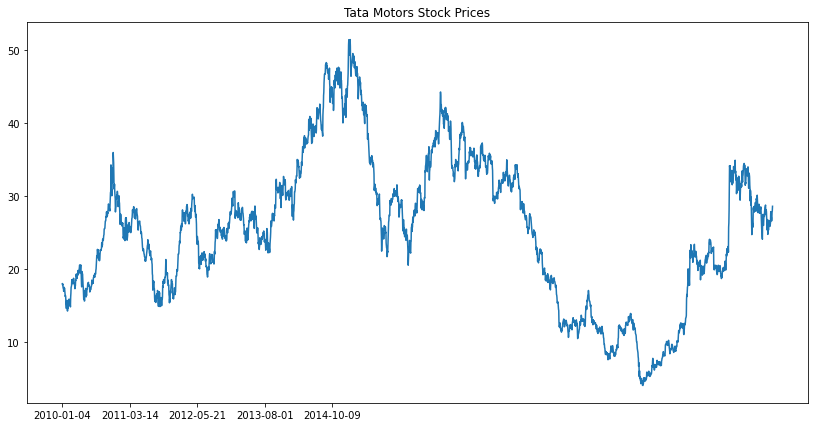

In [ ]:
plt.figure(figsize=(14,7))
plt.title('Tata Motors Stock Prices')
plt.plot(stock_price['Close'])
plt.xticks(np.arange(0,1500, 300), stock_price['Date'][0:1500:300])
plt.show()

In [ ]:
# calculating 7 day rolling mean
stock_price.rolling(7).mean().head(20)

,Open,High,Low,Close,Adj Close,Volume
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,17.585714,17.750000,17.394286,17.598572,16.497417,1.851643e+06
7,17.530000,17.657143,17.341429,17.508572,16.413047,1.682457e+06
8,17.485714,17.614285,17.284286,17.462857,16.370194,1.597243e+06
9,17.438571,17.574285,17.188572,17.370000,16.283147,1.487986e+06


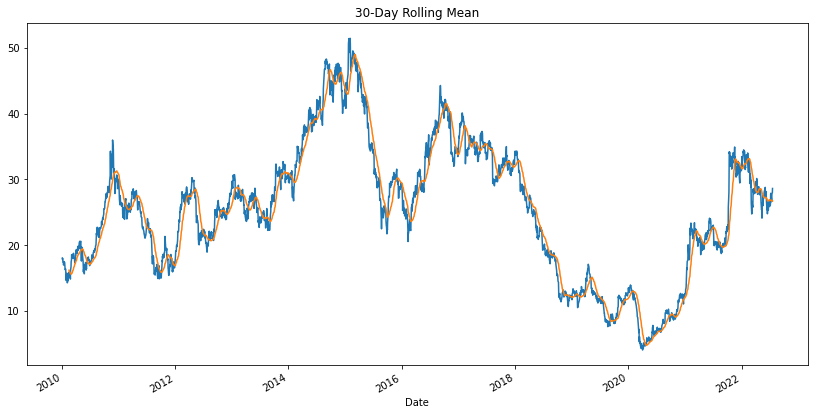

In [ ]:
# setting figure size
plt.figure(figsize=(14,7))
plt.title('30-Day Rolling Mean')
# plotting the close price and a 30-day rolling mean of close price
stock_price['Close'].plot()
stock_price.rolling(window=30).mean()['Close'].plot()

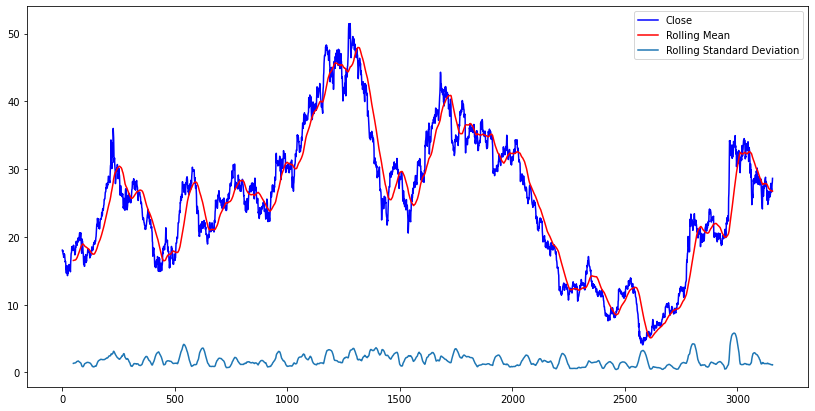

In [ ]:
# plotting the close price, 50-day rolling mean of close price and 50-day rolling standard Deviation
close = stock_price['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(14, 7))
stock_price['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

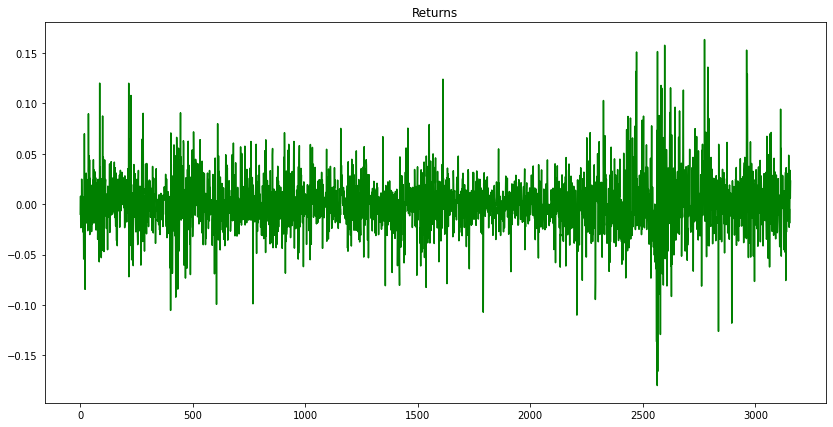

In [ ]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (14,7))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

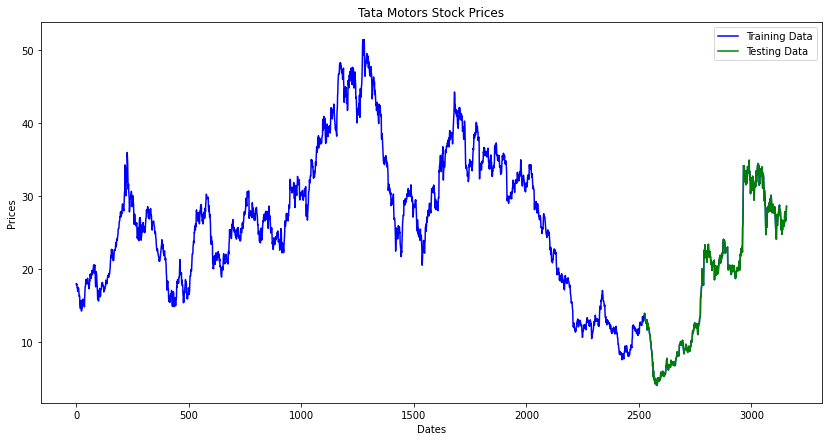

In [ ]:
train_data, test_data = stock_price[0:int(len(stock_price)*0.8)], stock_price[int(len(stock_price)*0.8):]
plt.figure(figsize=(14,7))
plt.title('Tata Motors Stock Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(stock_price['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')

plt.legend()

# Feature Engineering

In [ ]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(3157, 3650970)

In [ ]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [ ]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2010-01-04,18.030001,17.570000,18.090000,17.490000,2141700
2010-01-05,17.850000,17.780001,17.900000,17.620001,2022500
2010-01-06,17.990000,17.900000,18.010000,17.770000,2057800
2010-01-07,17.570000,17.389999,17.629999,17.340000,2706800
2010-01-08,17.400000,17.559999,17.559999,17.370001,1967200
...,...,...,...,...,...
2022-07-13,26.620001,26.450001,26.879999,26.450001,541600
2022-07-14,26.920000,26.389999,26.959999,26.280001,586700
2022-07-15,27.820000,27.700001,27.840000,27.510000,713000


In [ ]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


# Combined Stock Data

In [ ]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2010-01-04,18.030001,17.570000,18.090000,17.490000,2141700.0,"Bebo Khan't stop loving,Chor Bazaari top song ..."
2010-01-05,17.850000,17.780001,17.900000,17.620001,2022500.0,"Women say no to one-night stands,MJ's new trac..."
2010-01-06,17.990000,17.900000,18.010000,17.770000,2057800.0,Are ladies really THIS safe on Nagpur's buses?...
2010-01-07,17.570000,17.389999,17.629999,17.340000,2706800.0,"Dev Patel meets the Pintos,Rahman's going gree..."
2010-01-08,17.400000,17.559999,17.559999,17.370001,1967200.0,"Points table,Bicholim fire cell saved 79 lives..."
...,...,...,...,...,...,...
2022-03-25,28.400000,28.330000,28.410000,28.000000,505700.0,Speeding up; shortcuts and tackling unruly cus...
2022-03-28,28.540001,28.440001,28.700001,28.270000,329900.0,As fashion becomes democratic; demand for styl...
2022-03-29,29.150000,28.990000,29.590000,28.990000,1183500.0,Bobby Deol: Like my dad; I hope to be working ...
2022-03-30,28.250000,28.690001,28.780001,28.030001,868000.0,"I will not give in to trends: Dossmode,The tim..."


# Carrying out Sentimental Analysis on the News Headlines

In [ ]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2010-01-04,18.030001,17.570000,18.090000,17.490000,2141700.0,"Bebo Khan't stop loving,Chor Bazaari top song ...",,,,
2010-01-05,17.850000,17.780001,17.900000,17.620001,2022500.0,"Women say no to one-night stands,MJ's new trac...",,,,
2010-01-06,17.990000,17.900000,18.010000,17.770000,2057800.0,Are ladies really THIS safe on Nagpur's buses?...,,,,
2010-01-07,17.570000,17.389999,17.629999,17.340000,2706800.0,"Dev Patel meets the Pintos,Rahman's going gree...",,,,
2010-01-08,17.400000,17.559999,17.559999,17.370001,1967200.0,"Points table,Bicholim fire cell saved 79 lives...",,,,


In [ ]:
# importing requires libraries to analyze the sentiments

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2010-01-04,18.030001,17.570000,18.090000,17.490000,2141700.0,"Bebo Khan't stop loving,Chor Bazaari top song ...",-0.9983,0.119,0.792,0.088
2010-01-05,17.850000,17.780001,17.900000,17.620001,2022500.0,"Women say no to one-night stands,MJ's new trac...",-0.9986,0.115,0.813,0.072
2010-01-06,17.990000,17.900000,18.010000,17.770000,2057800.0,Are ladies really THIS safe on Nagpur's buses?...,-0.9995,0.146,0.772,0.082
2010-01-07,17.570000,17.389999,17.629999,17.340000,2706800.0,"Dev Patel meets the Pintos,Rahman's going gree...",-0.9996,0.147,0.775,0.078
2010-01-08,17.400000,17.559999,17.559999,17.370001,1967200.0,"Points table,Bicholim fire cell saved 79 lives...",-0.9997,0.148,0.764,0.088


In [ ]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2010-01-04,18.030001,-0.9983,0.119,0.792,0.088,17.570000,18.090000,17.490000,2141700.0
2010-01-05,17.850000,-0.9986,0.115,0.813,0.072,17.780001,17.900000,17.620001,2022500.0
2010-01-06,17.990000,-0.9995,0.146,0.772,0.082,17.900000,18.010000,17.770000,2057800.0
2010-01-07,17.570000,-0.9996,0.147,0.775,0.078,17.389999,17.629999,17.340000,2706800.0
2010-01-08,17.400000,-0.9997,0.148,0.764,0.088,17.559999,17.559999,17.370001,1967200.0


# Saving Stock Data

In [ ]:
# writing the prepared stock_data to disk
stock_data.to_csv('/content/drive/MyDrive/TSF-GRIP/stock_datafinal.csv')

# Reading Stock Data

In [ ]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('/content/drive/MyDrive/TSF-GRIP/stock_datafinal.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2010-01-04,18.030001,-0.9983,0.119,0.792,0.088,17.570000,18.090000,17.490000,2141700.0
2010-01-05,17.850000,-0.9986,0.115,0.813,0.072,17.780001,17.900000,17.620001,2022500.0
2010-01-06,17.990000,-0.9995,0.146,0.772,0.082,17.900000,18.010000,17.770000,2057800.0
2010-01-07,17.570000,-0.9996,0.147,0.775,0.078,17.389999,17.629999,17.340000,2706800.0
2010-01-08,17.400000,-0.9997,0.148,0.764,0.088,17.559999,17.559999,17.370001,1967200.0


# Feature Engineering of Stock Data

In [ ]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(3083, 9)

In [ ]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [ ]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3.083000e+03
mean,25.288339,-0.938736,0.130852,0.781060,0.088078,25.290451,25.550032,25.014616,1.684813e+06
std,10.186199,0.334288,0.017623,0.022728,0.014222,10.194309,10.272440,10.109752,9.505063e+05
min,4.080000,-1.000000,0.070000,0.705000,0.044000,4.200000,4.240000,3.920000,0.000000e+00
25%,18.190001,-0.999900,0.120000,0.765000,0.079000,18.170000,18.399999,17.890000,1.042800e+06
50%,25.590000,-0.999700,0.132000,0.778000,0.088000,25.549999,25.850000,25.280001,1.466800e+06
75%,32.200001,-0.999400,0.142000,0.794000,0.097000,32.230002,32.465000,31.870001,2.050950e+06
max,51.470001,0.999900,0.199000,0.877000,0.159000,51.259998,51.799999,50.650002,1.085910e+07


In [ ]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3083 entries, 2010-01-04 to 2022-03-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     3083 non-null   float64
 1   compound  3083 non-null   float64
 2   negative  3083 non-null   float64
 3   neutral   3083 non-null   float64
 4   positive  3083 non-null   float64
 5   Open      3083 non-null   float64
 6   High      3083 non-null   float64
 7   Low       3083 non-null   float64
 8   Volume    3083 non-null   float64
dtypes: float64(9)
memory usage: 240.9+ KB


In [ ]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-12,17.598572,-0.998843,0.132286,0.783429,0.084143,17.585714,17.750000,17.394286,1.851643e+06
2010-01-13,17.508572,-0.998986,0.135571,0.780000,0.084429,17.530000,17.657143,17.341429,1.682457e+06
2010-01-14,17.462857,-0.998529,0.137714,0.771571,0.090857,17.485714,17.614285,17.284286,1.597243e+06


In [ ]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2010-01-04,18.030001,-0.9983,0.119,0.792,0.088,17.570000,18.090000,17.490000,2141700.0
2010-01-05,17.850000,-0.9986,0.115,0.813,0.072,17.780001,17.900000,17.620001,2022500.0
2010-01-06,17.990000,-0.9995,0.146,0.772,0.082,17.900000,18.010000,17.770000,2057800.0
2010-01-07,17.570000,-0.9996,0.147,0.775,0.078,17.389999,17.629999,17.340000,2706800.0
2010-01-08,17.400000,-0.9997,0.148,0.764,0.088,17.559999,17.559999,17.370001,1967200.0
...,...,...,...,...,...,...,...,...,...
2022-03-25,28.400000,-0.9999,0.160,0.774,0.066,28.330000,28.410000,28.000000,505700.0
2022-03-28,28.540001,-0.9999,0.151,0.763,0.086,28.440001,28.700001,28.270000,329900.0
2022-03-29,29.150000,-0.9998,0.131,0.789,0.080,28.990000,29.590000,28.990000,1183500.0


# Data Preparation for Modelling
Now we will use the Combined data of Sentiment Analysis score and the Historical prices data for predicting stock prices using Stack LSTM


In [ ]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 2465
Number of records in Test Data: 618


In [ ]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2010-01-05    17.850000
2010-01-06    17.990000
2010-01-07    17.570000
2010-01-08    17.400000
2010-01-11    17.370001
                ...    
2022-03-25    28.400000
2022-03-28    28.540001
2022-03-29    29.150000
2022-03-30    28.250000
2022-03-31    27.950001
Name: Close, Length: 3082, dtype: float64

In [ ]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2010-01-05,17.850000,17.990000,-0.9986,-0.9995,2022500.0,17.780001,17.900000,17.620001
2010-01-06,17.990000,17.570000,-0.9995,-0.9996,2057800.0,17.900000,18.010000,17.770000
2010-01-07,17.570000,17.400000,-0.9996,-0.9997,2706800.0,17.389999,17.629999,17.340000
2010-01-08,17.400000,17.370001,-0.9997,-0.9988,1967200.0,17.559999,17.559999,17.370001
2010-01-11,17.370001,16.980000,-0.9988,-0.9974,988800.0,17.750000,17.750000,17.280001
2010-01-12,16.980000,17.400000,-0.9974,-0.9993,1076700.0,17.150000,17.309999,16.889999
2010-01-13,17.400000,17.530001,-0.9993,-0.9954,957400.0,17.180000,17.440001,17.120001
2010-01-14,17.530001,17.340000,-0.9954,-0.9981,1426000.0,17.469999,17.600000,17.219999
2010-01-15,17.340000,17.400000,-0.9981,-0.9756,1293000.0,17.570000,17.730000,17.100000


# Setting the Target Variable and the Feature Dataset

In [ ]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2010-01-05    17.990000
2010-01-06    17.570000
2010-01-07    17.400000
2010-01-08    17.370001
2010-01-11    16.980000
                ...    
2022-03-24    28.400000
2022-03-25    28.540001
2022-03-28    29.150000
2022-03-29    28.250000
2022-03-30    27.950001
Name: close_price_shifted, Length: 3081, dtype: float64

In [ ]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2010-01-05,17.850000,-0.9986,-0.9995,2022500.0,17.780001,17.900000,17.620001
2010-01-06,17.990000,-0.9995,-0.9996,2057800.0,17.900000,18.010000,17.770000
2010-01-07,17.570000,-0.9996,-0.9997,2706800.0,17.389999,17.629999,17.340000
2010-01-08,17.400000,-0.9997,-0.9988,1967200.0,17.559999,17.559999,17.370001
2010-01-11,17.370001,-0.9988,-0.9974,988800.0,17.750000,17.750000,17.280001
...,...,...,...,...,...,...,...
2022-03-24,28.580000,-0.9999,-0.9999,685600.0,28.330000,28.650000,28.170000
2022-03-25,28.400000,-0.9999,-0.9999,505700.0,28.330000,28.410000,28.000000
2022-03-28,28.540001,-0.9999,-0.9998,329900.0,28.440001,28.700001,28.270000


# Scaling the Target Variable and the Feature Dataset

In [ ]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.41886475, -0.99859993, -0.99949997, ..., -0.42286436,
         -0.42556769, -0.41365288],
        [-0.41295633, -0.99949997, -0.99959998, ..., -0.41776453,
         -0.42094196, -0.40723307],
        [-0.43068159, -0.99959998, -0.99969998, ..., -0.43943903,
         -0.43692181, -0.42563666],
        ...,
        [ 0.03228531, -0.99989999, -0.99979999, ...,  0.03017433,
          0.02859552,  0.04215703],
        [ 0.0580291 , -0.99979999, -0.99989999, ...,  0.05354871,
          0.06602189,  0.07297235],
        [ 0.0200464 , -0.99989999, -0.99989999, ...,  0.04079907,
          0.03195969,  0.0318853 ]]), array([[-0.41295633],
        [-0.43068159],
        [-0.4378561 ],
        ...,
        [ 0.0580291 ],
        [ 0.0200464 ],
        [ 0.00738555]]))

# Dividing the dataset into Training and Test
Normally for any other, we use dataset train_test_split from sklearn package, but for time series data like stock prices which is dependent on date, the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always dependent on the previous date record

In [ ]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (2465, 7) and y: (2465, 1)
Number of rows and columns in the Test set X: (615, 7) and y: (615, 1)


# Reshaping the Feature Dataset for LSTM


In [ ]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (2465, 7, 1)
Shape of Test set X: (615, 7, 1)


# Building a LSTM (Long Short Term Memory) Model to predict Stock Prices

In [ ]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2000)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))

model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

Epoch 1/10
161/161 [==============================] - 12s 40ms/step - loss: 0.0498 - val_loss: 0.0183
Epoch 2/10
161/161 [==============================] - 3s 19ms/step - loss: 0.0159 - val_loss: 0.0047
Epoch 3/10
161/161 [==============================] - 3s 18ms/step - loss: 0.0036 - val_loss: 9.4462e-04
Epoch 4/10
161/161 [==============================] - 3s 18ms/step - loss: 0.0023 - val_loss: 7.8778e-04
Epoch 5/10
161/161 [==============================] - 3s 18ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 6/10
161/161 [==============================] - 3s 18ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/10
161/161 [==============================] - 3s 18ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 8/10
161/161 [==============================] - 3s 18ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 9/10
161/161 [==============================] - 3s 18ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/10
161/161 [==============================] - 3s 18ms/step - loss: 0.0019

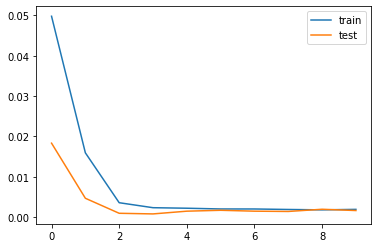

In [ ]:

# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
history = model.fit(X_train, y_train, validation_split=0.35, epochs=10, batch_size=10, verbose=1)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('/content/drive/MyDrive/TSF-GRIP/model.h5')
print('Model is saved to the disk')

Model is saved to the disk


# Testing the LSTM Model with the test data and calculating RMSE(Root Mean Square Error):

In [ ]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

615/615 [==============================] - 2s 3ms/step - loss: 0.0028
Train Loss = 0.0014
Test Loss = 0.0028


In [ ]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[10.772747],
       [10.799676],
       [10.918085],
       [11.891851],
       [11.901546]], dtype=float32)

In [ ]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 20.1858


In [ ]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 20.1858


In [ ]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

# Plotting the Predictions against unseen data

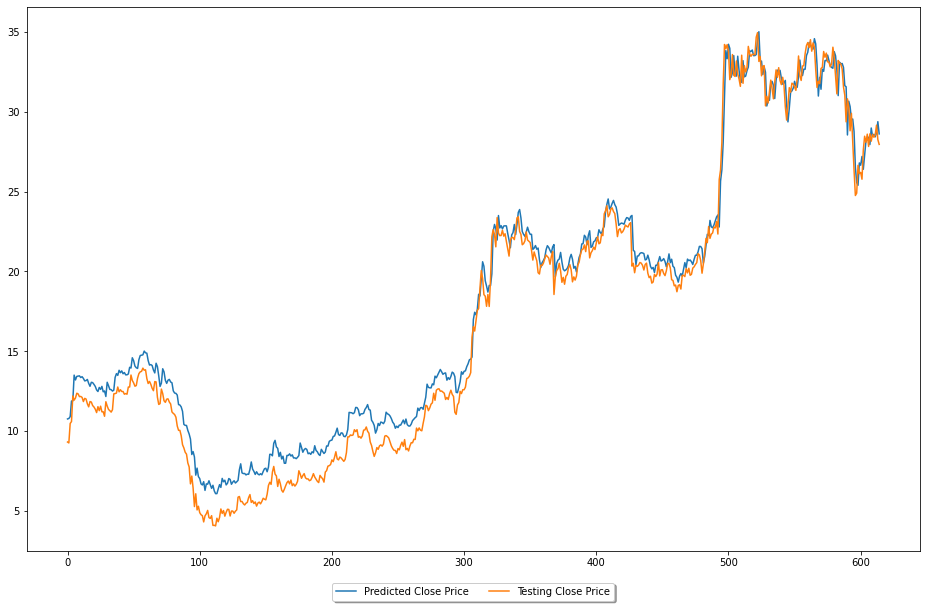

In [ ]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()